In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import *
import os

2025-03-07 12:57:41.558165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 12:57:41.558241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 12:57:41.559991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 12:57:41.569323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-07 12:57:42.674737: W tensorflow/compiler/tf2

In [2]:
pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 12.5 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105789 sha256=3e2e30f83ee19d749ab4e3852dd9acf195ddfcf22a8b469dd5c239c12b05cb4b
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20
Note: you may need to restart the kernel to use updated packages.


In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/bilalakgz/brain-tumor-mri-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  shruthi2905


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/bilalakgz/brain-tumor-mri-dataset


100%|██████████| 92.1M/92.1M [00:01<00:00, 76.1MB/s]


In [4]:
main_dataset_dir = "brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/"
os.listdir(main_dataset_dir + "Training")


['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']

In [5]:
main_dataset_labels = np.array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [6]:
train_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Training",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,
    validation_split=0.2,
    subset="training"
)

# Normalize the images using tf.map()
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

validation_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Training",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,
    validation_split=0.2,
    subset="validation"
)

# Normalize the images using tf.map()
validation_dataset = validation_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

test_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Testing",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,   
)

# Normalize the images using tf.map()
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32)/255.0,y))

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


2025-03-07 12:59:01.752658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-07 12:59:01.837868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-07 12:59:01.838204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


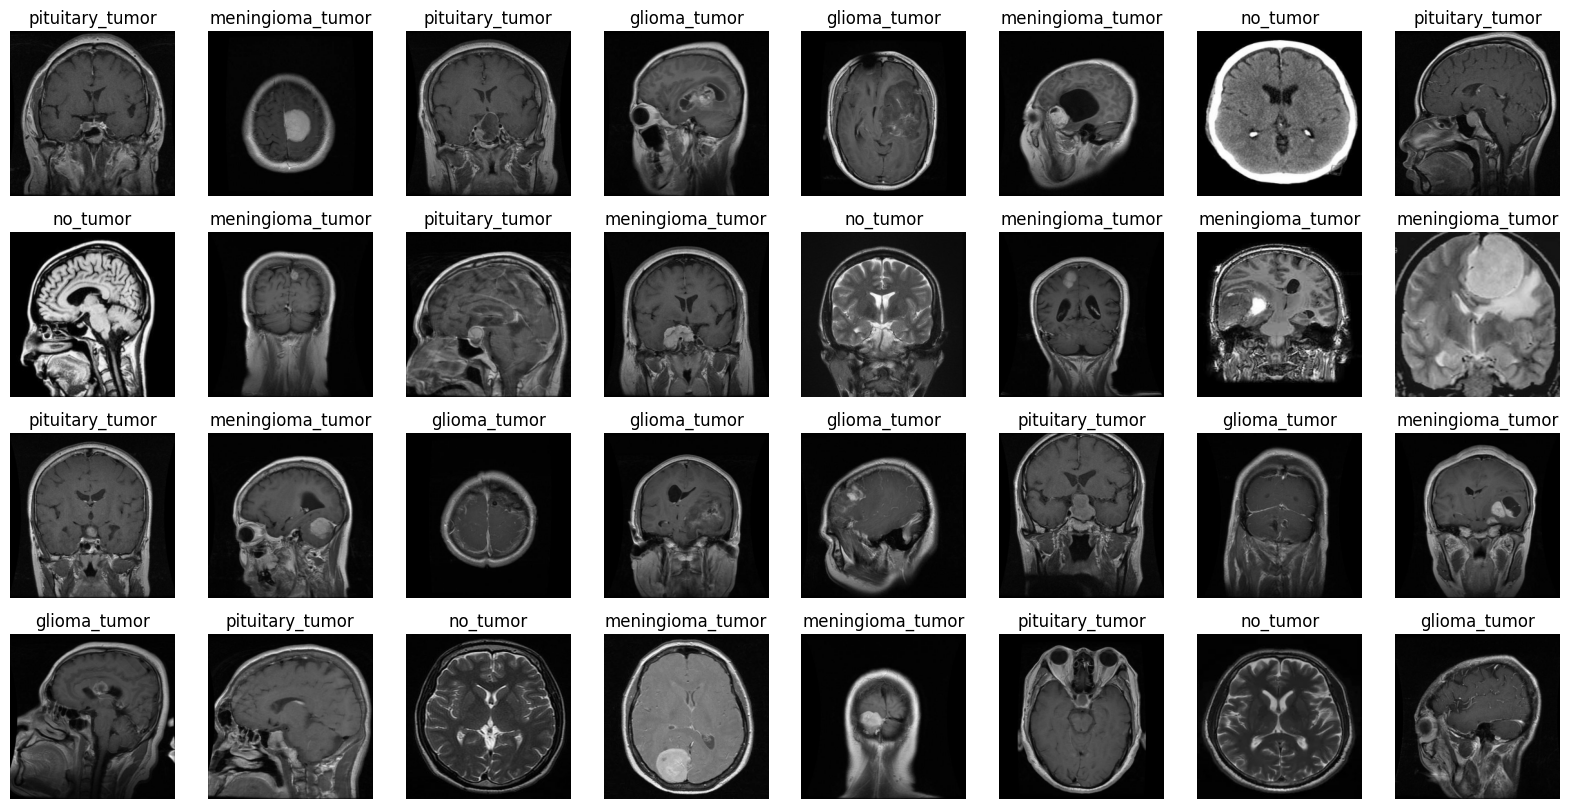

In [7]:
plt.figure(figsize=(20, 10))
i = 1
for image, label in train_dataset.take(1).unbatch():
    image = image.numpy()
    label = main_dataset_labels[np.argmax(label.numpy())]
    plt.subplot(4, 8, i)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    i += 1

In [8]:
def VGG16_based_model():
    base_model = VGG16(
        weights = "imagenet", 
        input_shape = (256, 256, 3),
        include_top = False, 
    )

    base_model.trainable = False

    input = Input((256, 256, 3))
    x = RandomRotation(factor=(-0.2, 0.2))(input)
    x = RandomZoom(height_factor=0.1, width_factor=0.1)(x)
    x = RandomContrast(factor= (0.8, 1.2))(x)
    x = base_model(input, training=False)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    output = Dense(4, activation="linear")(x)
    
    return Model(inputs=input, outputs=output),base_model

In [9]:
model_1, base_models_1 = VGG16_based_model()

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (Batch  (None, 32768)             131072    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                             

In [11]:
model_1.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=["accuracy"])

In [14]:
callbacks_1 = [
    EarlyStopping(
        monitor = "val_loss", 
        min_delta = 1e-3, 
        patience = 3,
        start_from_epoch = 10,
        restore_best_weights = True, 
    ),
]

In [15]:
hist_1 = model_1.fit(train_dataset, epochs=5, callbacks=callbacks_1, validation_data=validation_dataset)


Epoch 1/5


2025-03-07 13:00:17.038892: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-07 13:00:25.975100: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efc035227b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-07 13:00:25.975172: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2025-03-07 13:00:25.982197: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741352426.106030     731 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 [==============================] - 32s 260ms/step - loss: 4.1847 - accuracy: 0.7892 - val_loss: 1.4001 - val_accuracy: 0.7909
Epoch 2/5
72/72 [==============================] - 10s 138ms/step - loss: 0.7916 - accuracy: 0.9260 - val_loss: 0.7789 - val_accuracy: 0.8624
Epoch 3/5
72/72 [==============================] - 10s 136ms/step - loss: 0.3041 - accuracy: 0.9630 - val_loss: 0.6592 - val_accuracy: 0.8972
Epoch 4/5
72/72 [==============================] - 10s 139ms/step - loss: 0.1355 - accuracy: 0.9782 - val_loss: 0.8822 - val_accuracy: 0.8798
Epoch 5/5
72/72 [==============================] - 10s 140ms/step - loss: 0.3145 - accuracy: 0.9673 - val_loss: 1.1045 - val_accuracy: 0.8972


In [16]:
model_1.evaluate(test_dataset)

13/13 [==============================] - 4s 285ms/step - loss: 17.2482 - accuracy: 0.7208


[17.2481746673584, 0.720812201499939]

In [17]:
for layer in base_models_1.layers:
    layer.trainable = True

In [18]:
model_1.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(1e-5), metrics=["accuracy"])

In [19]:
hist_1_2 = model_1.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks = callbacks_1)

Epoch 1/10
72/72 [==============================] - 12s 140ms/step - loss: 0.1216 - accuracy: 0.9834 - val_loss: 1.0706 - val_accuracy: 0.9111
Epoch 2/10
72/72 [==============================] - 10s 139ms/step - loss: 0.0572 - accuracy: 0.9904 - val_loss: 1.0803 - val_accuracy: 0.9111
Epoch 3/10
72/72 [==============================] - 10s 139ms/step - loss: 0.0492 - accuracy: 0.9895 - val_loss: 1.1122 - val_accuracy: 0.9129
Epoch 4/10
72/72 [==============================] - 10s 140ms/step - loss: 0.0531 - accuracy: 0.9939 - val_loss: 1.1255 - val_accuracy: 0.9181
Epoch 5/10
72/72 [==============================] - 10s 138ms/step - loss: 0.0283 - accuracy: 0.9939 - val_loss: 1.1709 - val_accuracy: 0.9216
Epoch 6/10
72/72 [==============================] - 10s 140ms/step - loss: 0.0447 - accuracy: 0.9935 - val_loss: 1.1253 - val_accuracy: 0.9286
Epoch 7/10
72/72 [==============================] - 10s 138ms/step - loss: 0.0265 - accuracy: 0.9948 - val_loss: 1.1260 - val_accuracy: 0.9286

In [20]:
model_1.evaluate(test_dataset)

13/13 [==============================] - 2s 101ms/step - loss: 31.7683 - accuracy: 0.7310


[31.768259048461914, 0.7309644818305969]

In [21]:
model_1.save("MRI_VGG_16.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


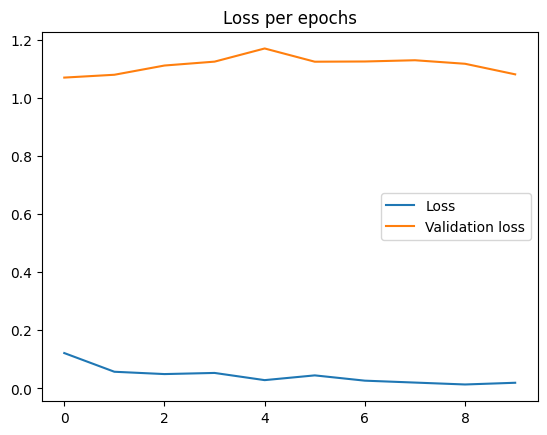

In [22]:
hist = hist_1_2.history
plt.plot(hist["loss"], label="Loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.title("Loss per epochs")
plt.legend()
plt.show()

In [23]:
base_models_1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [24]:
counts = tf.Variable([0, 0, 0, 0], dtype=tf.float32)
for _, label in train_dataset.unbatch().take(-1):
    counts.assign_add(label)

In [25]:
counts

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([669., 652., 317., 658.], dtype=float32)>

In [26]:
def visualize_result(dataset):
    plt.figure(figsize=(20, 12))
    i = 1
    for image, label in dataset.take(1).unbatch().take(32):
        image = image.numpy()
        label = main_dataset_labels[np.argmax(label.numpy())]
        predicted_label = main_dataset_labels[np.argmax(model_1.predict(np.reshape(image, (1,) + image.shape), verbose=False))]
        plt.subplot(4, 8, i)
        plt.imshow(image)
        plt.title(f"Label: {label}\nPredicted: {predicted_label}")
        plt.axis("off")
        i += 1

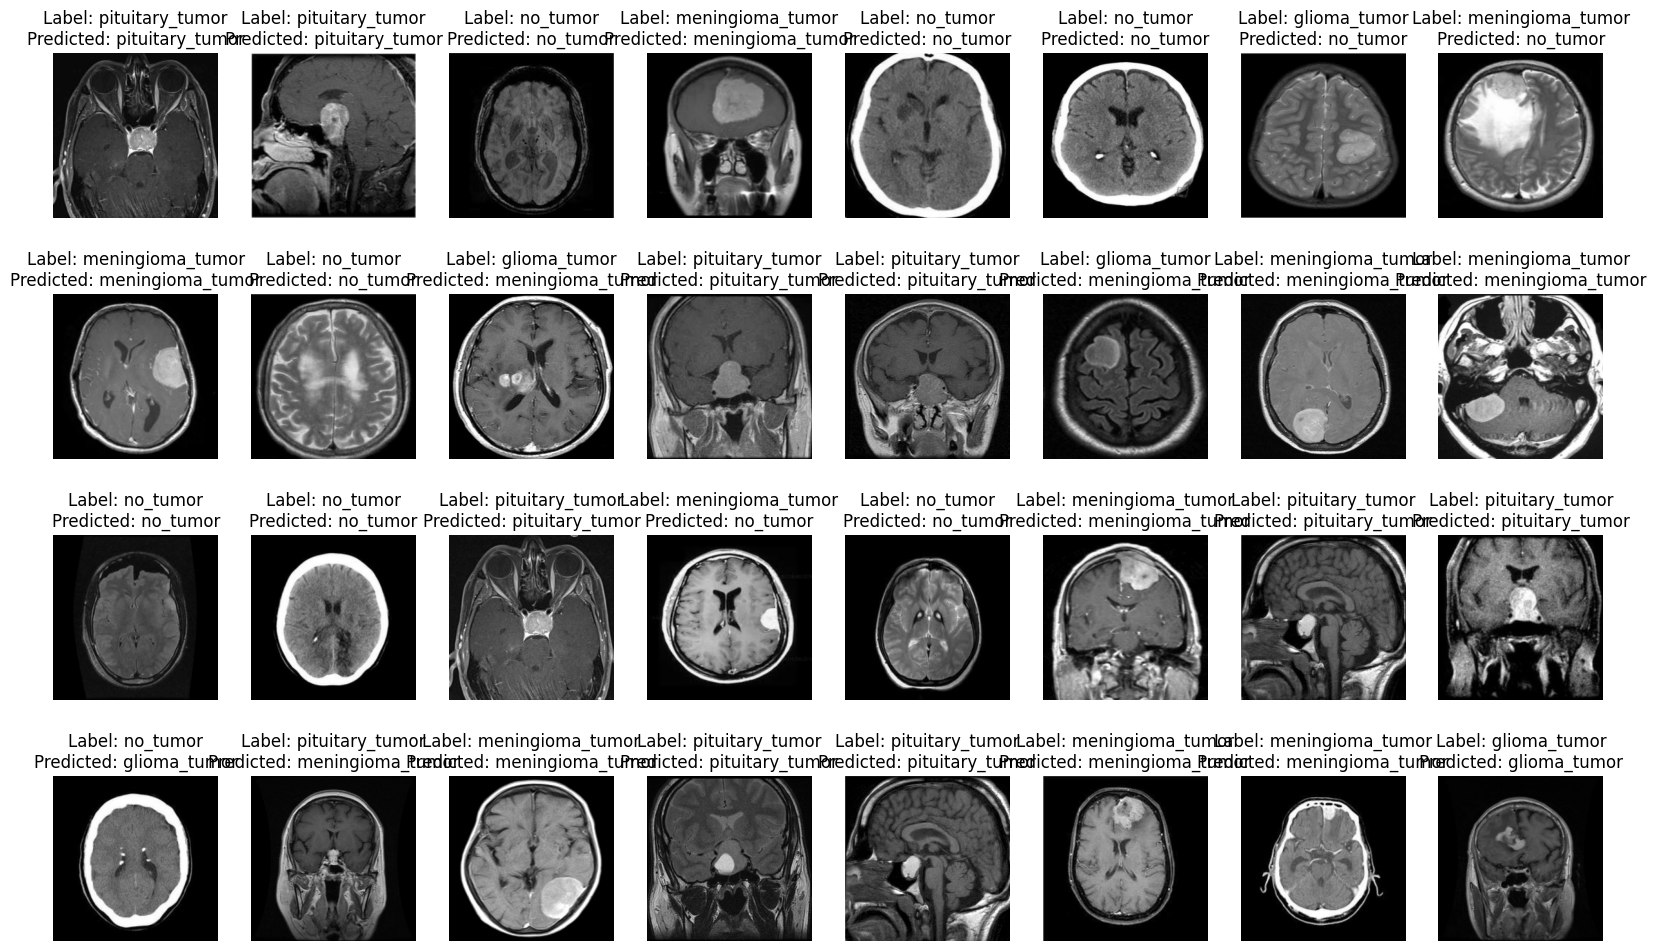

In [27]:
visualize_result(test_dataset)